In [1]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import csv
import textwrap


In [2]:
import sys
sys.path.append('/Users/gabriellachronis/src/static_bert')

from helpers import bert_helper, datasets, grinders

import os, shutil
import numpy as np
import csv
import pickle

import pandas as pd

In [3]:
# initialize BERT model
(model, tokenizer) = bert_helper.initialize()

INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /Users/gabriellachronis/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
INFO:pytorch_pretrained_bert.modeling:extracting archive file /Users/gabriellachronis/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /var/folders/9m/vzvx58rs51v_x5nm620fz4xr0000gn/T/tmpjxf6kcvh
INFO:pytorch_pretrained_bert.modeling:Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 3

In [4]:
# get the sentences for the words

#words = ["madhouse", "asylum"]
#words = ["bishop", "rook"]
#words = ["hand", "thumb"]
#words = ["mouth", "lip"]
#words = ["goal", "quest"]
words = ["bubble", "suds"]


tokens = []

for word in words:
    with open('../data/word_data/'+word+'/BNC_tokens.csv', mode="r") as infile:
        fieldnames = ['word', 'sentence', 'tag', 'bnc_index']

        reader = csv.DictReader(infile, delimiter="\t", fieldnames=fieldnames)
        for row in reader:
            #print(row['vector'][2:-2])
            vectors = bert_helper.get_bert_vectors_for(row['word'], row['sentence'] , model, tokenizer)
            
            # looking at layer 8
            layer_vector = vectors[8]
            row['vector'] =  layer_vector
            tokens.append(row)

        
data = pd.DataFrame.from_records(tokens)

print(data)



       word                                           sentence    tag  \
0    bubble  The removal of excess weed can guard against g...  SUBST   
1    bubble                                Bubble nesting cats  SUBST   
2    bubble  That the air bubble er the gas bubble , I keep...  SUBST   
3    bubble  We could vaguely make out a few buildings as w...  SUBST   
4    bubble     But without love , passion was just a bubble .  SUBST   
..      ...                                                ...    ...   
124    suds  It is only then that I can get up and interpos...  SUBST   
125    suds                             suds of urinous seas .  SUBST   
126    suds  With partner Griff Rhys Jones , 38 , he sends ...   VERB   
127    suds           A trail of suds as long as a day 's walk  SUBST   
128    suds  They ducked under spellbound apple boughs lade...  SUBST   

       bnc_index                                             vector  
0    BNC_1175924  [0.7302437, -0.9648803, 0.4336715, 

In [5]:
# TSNE

In [6]:
X = data['vector']
X = X.to_list()
y = data['word']
contexts = data['sentence']

feat_cols = [ 'dimension'+str(i) for i in range(len(X[0])) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
df['context'] = contexts

X, y = None, None 

print('Size of the dataframe: {}'.format(df.shape))


Size of the dataframe: (129, 771)


In [7]:
data_subset = df[feat_cols].values


time_start = time.time()
# use low perplexity because N is very small
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 129 samples in 0.005s...
[t-SNE] Computed neighbors for 129 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 129 / 129
[t-SNE] Mean sigma: 3.606675
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.937210
[t-SNE] KL divergence after 300 iterations: 2.239012
t-SNE done! Time elapsed: 0.19936680793762207 seconds


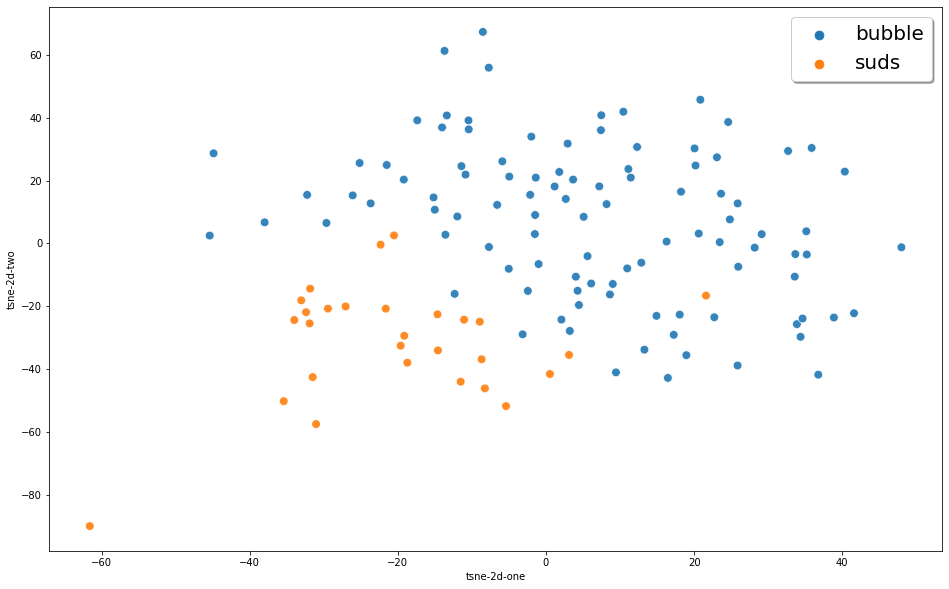

In [8]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    #palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=0.9,
    size="y",
    sizes = (75,75)
)
ax.legend(prop={'size': 20}, title=None, shadow=True)


for line in range(0,df.shape[0]):
    if line % 1 == 0:
        text = df.context[line]
        #text = textwrap.wrap(text, width=40)
        text = '\n'.join(text)
        #p1.text(df["tsne-2d-one"][line]+0.2, df["tsne-2d-two"][line], text, horizontalalignment='left', size='medium', color='black', weight='semibold')
       

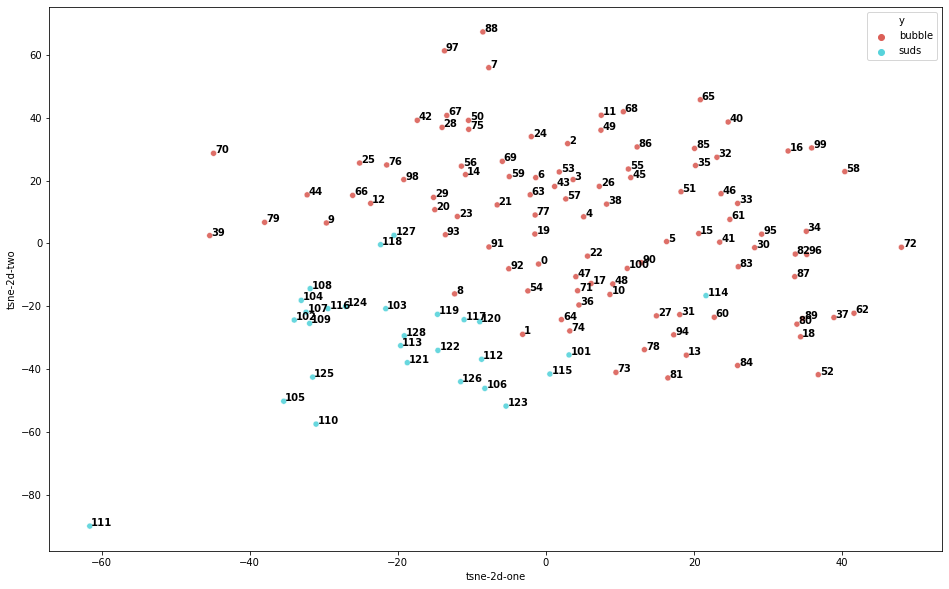

In [9]:
# get one with the indices annotated so we can pick out which sentence is where


df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
p1 = sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df,
    legend="full",
    alpha=0.9
)

for line in range(0,df.shape[0]):
    if line % 1 == 0:
        #text = df.context[line]
        text = str(line)
        text = textwrap.wrap(text, width=40)
        text = '\n'.join(text)
        p1.text(df["tsne-2d-one"][line]+0.2, df["tsne-2d-two"][line], text, horizontalalignment='left', size='medium', color='black', weight='semibold')


In [10]:
pd.set_option('display.max_colwidth', -1)
print(data['sentence'].to_string())

0      The removal of excess weed can guard against gas bubble disease .                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

<ipython-input-10-0675cca3f9ab>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)
